<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# [Scénarios d'Exploration Statistique](https://github.com/wikistat/Exploration)

# Exploration de données d'enquête en <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>:  explication du seuil de revenu 

### Résumé
Analyse de données extraites d'un recensement aux USA de 1994. Préparation des données, exploration élémentaire et multidimensionnelle ([ACP](http://wikistat.fr/pdf/st-m-explo-acp.pdf), [AFCM](http://wikistat.fr/pdf/st-m-explo-afcm.pdf)), [classification non supervisée](http://wikistat.fr/pdf/st-m-explo-classif.pdf). L'objectif est de préparer l'[étape suivante](https://github.com/wikistat/Apprentissage/tree/master/Adult-Census) consistant à modéliser / prévoir le niveau de revenu.

## Introduction
Des données publiques disponibles sur le site [UCI repository](http://archive.ics.uci.edu/ml/) sont extraites de la base de données issue du recensement réalisé aux Etats Unis en 1994. Ces données son largement utilisées et font référence comme outil de *benchmark* pour comparer les performances de méthodes d’apprentissage ou modélisation statistique. L’objectif est alors de prévoir la variable binaire « revenu annuel » supérieur ou inférieur à 50k$. Le travail décrit dans ce document est un préalable, il propose une exploration des données pour en appréhender les grandes structures. Il ne s’agit pas encore de données massives mais 32.561 individus sont décrits par les 14 variables du tableau ci-dessous :

Num| Libellé |	Ensemble de valeurs
-|--|--|--
1|`Age`|	real
2|	`workClass`|	Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked
3|	`fnlwgt`|	real
4|	`education`|	Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
5|	`educNum`|	integer
6|	`mariStat`|	Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse
7|	`occup`|	Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
8|	`relationship`|	Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
9|	`origEthn`|	White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
10|	`sex`|	Female, Male
11|	`capitalGain`|	real  
12|	`capitalLoss`|	real
13|	`hoursWeek`|	real
14|	`nativCountry`|	United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands
15|	`income`|		>50K, <=50K

Une première étape permet de vérifier, sélectionner, recoder les données, avant d’aborder des outils plus élaborés. Les questions suivent la chronologie de ce déroulement.

La deuxième étape cherchant un meilleur modèle de prévision du dépassement de seuil de revenu est détaillée dans un [scénario](https://github.com/wikistat/Apprentissage/tree/master/Adult-Census) de la [saison 3: Apprentissage](https://github.com/wikistat/Apprentissage).


**Répondre aux questions en s'aidant des résultats des exécutions**.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import scipy.stats 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
pd.options.mode.chained_assignment = None  # default='warn'
from mca import MCA

## 1 Préparation des données
La lecture et la transformation des données est obtenue directement en exécutant un code source en R. Consulter le code du programme pour comprendre les transformations qui ont été réalisées sur les données brutes. Cette étape a été largement anticipée et simplifiée par la fourniture du programe afférent. Ne pas oublier qu'elle est essentielle et occupe la plus grande partie du temps nécessaire à une analyse. Elle aurait pu être rendue plus efficace (programme plus concis et exécution plus rapide) en utilisant la librairie [`dplyr`](https://cran.r-project.org/web/packages/dplyr/dplyr.pdf) très adaptée à cet usage.

Charger les [données](https://www.math.univ-toulouse.fr/~besse/Wikistat/data/adultCensus.dat) et le [programme](https://www.math.univ-toulouse.fr/~besse/Wikistat/programmes/dataPrepAdultCensus.R) dans le répertoire courant (`path=""`) en même temps que ce tutoriel ou changer de chemin pour y accéder directement. 

In [2]:
def create_categorical_data(df,column_name, cat_name_dic):
    cat_columns = pd.Categorical(df[column_name],ordered=False)
    new_categorie = [cat_name_dic[old_name] for old_name in cat_columns.categories]
    return cat_columns.rename_categories(new_categorie)

In [3]:
def capital_gain(data):
    txt=""
    if type(data)!=int:
        txt=np.nan
    elif data <= 0:
        txt = 'None'
    elif data <= np.median(adult[adult["capitalGain"]>0]["capitalGain"]):
        txt = 'cgLow'
    else :
        txt = 'cgHigh'     
    return txt

def capital_loss(data):
    txt=""
    if type(data)!=int:
        txt=np.nan
    elif data <= 0:
        txt = 'None'
    elif data <= np.median(adult[adult["capitalLoss"]>0]["capitalLoss"]):
        txt = 'clLow'
    else :
        txt = 'clHigh'     
    return txt

In [4]:
# Chemin pour charger au moment de l'exécution:
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/programmes/"
path=""
donnees=path+'adultes.csv'
listeVar=['age','workClass','fnlwgt','education','educNum','mariStat','occup','relationship','origEthn',
          'sex','capitalGain','capitalLoss','hoursWeek','nativCountry', 'income']
adult = pd.read_table(path+'adultes.csv',
                        sep=',',header=None, index_col=None, names=listeVar, 
                      dtype={"workClass":object,"education":object,"mariStat":object,"occup":object, 
                             "relationship":object,"origEthn":object, "sex":object, "nativCountry":object,
                             "income":object})

#WORKCLASS
cat_name_dic = {' Private' : 'Private', 
                ' Self-emp-not-inc':'Self-Employed', 
                ' Self-emp-inc':'Self-Employed', 
                ' Federal-gov':'Federal-Gov', 
                ' Local-gov':'Other-Gov', 
                ' State-gov':'Other-Gov',
                ' Without-pay':'Not-Working',
                ' Never-worked':'Not-Working'}
adult["workClass"]=adult.workClass.map(cat_name_dic)

#EDUCATION
cat_name_dic = {' HS-grad' : 'HS-Graduate', 
                ' Bachelors':'Bachelors', 
                ' Some-college':'HS-Graduate', 
                ' 11th': 'Dropout', 
                ' Prof-school':'Prof-school', 
                ' Assoc-acdm':'Associates',
                ' Assoc-voc':'Associates',
                ' 9th':'Dropout', 
                ' 7th-8th':'Dropout', 
                ' 12th':'Dropout',
                ' Masters':'Masters', 
                ' 1st-4th':'Dropout',
                ' 10th':'Dropout',
                ' 5th-6th':'Dropout', 
                ' Doctorate':'Doctorate', 
                ' Preschool':'Dropout'}

adult["education"]=adult.education.map(cat_name_dic)


#MARISTAT
cat_name_dic = {' Married-civ-spouse':'Married',
                ' Divorced':'Not-Married',
                ' Never-married':'Never-married', 
                ' Separated':'Not-Married',
                ' Widowed':'Widowed',
                ' Married-spouse-absent':'Not-Married',
                ' Married-AF-spouse':'Married'}


adult["mariStat"]=adult.mariStat.map(cat_name_dic)


#OCCUP
cat_name_dic = {' Tech-support':'Other-occups', 
                ' Craft-repair':'Blue-Collar', 
                ' Other-service':'Service', 
                ' Sales':'Sales', 
                ' Exec-managerial':'White-Collar', 
                ' Prof-specialty':'Professional',
                ' Handlers-cleaners':'Blue-Collar', 
                ' Machine-op-inspct':'Blue-Collar', 
                ' Adm-clerical':'Admin', 
                ' Farming-fishing':'Blue-Collar', 
                ' Transport-moving':'Blue-Collar',
                ' Priv-house-serv':'Service', 
                ' Protective-serv':'Other-occups'}

adult["occup"]=adult.occup.map(cat_name_dic)


#RELATIONSHIP
cat_name_dic = {' Wife':'Wife', 
                ' Own-child':'Own-child', 
                ' Husband':'Husband', 
                ' Not-in-family':'Not-in-family', 
                ' Other-relative':'Other-relative', 
                ' Unmarried':'Unmarried'}

adult["relationship"]=adult.relationship.map(cat_name_dic)


#ORIGETHN
cat_name_dic = {'White':' White',
                'Asian':' Asian-Pac-Islander',
                'Amer-Indian':' Amer-Indian-Eskimo', 
                'Other':' Other',
                'Black':' Black'}

a = [x[1] for x in cat_name_dic.items()]
b = [x[0] for x in cat_name_dic.items()]

dico = dict(zip(a, b))

adult["origEthn"]=adult.origEthn.map(dico)


#SEX
cat_name_dic = {' Female':'Female', 
                ' Male':'Male'}


adult["sex"]=adult.sex.map(cat_name_dic)


#LCAPITALGAIN
adult["LcapitalGain"]=np.log(1+adult["capitalGain"])

                             
#LCAPITALLOSS
adult["LcapitalLoss"]=np.log(1+adult["capitalLoss"])

#CAPITALGAIN
adult["capitalGain"]=list(map(capital_gain,adult.capitalGain))


#CAPITALLOSS
adult["capitalLoss"]=list(map(capital_loss,adult.capitalLoss))



#NATIVECOUNTRY
cat_name_dic = {' United-States':'United-States', 
                ' Cambodia':'S-Asia', 
                ' England':'British-Commonwealth', 
                ' Canada':'British-Commonwealth',
                ' Puerto-Rico':'Latin-America',
                ' Germany':'Euro_1',
                ' Outlying-US(Guam-USVI-etc)': 'Latin-America',
                ' India':'British-Commonwealth',
                ' Japan':'SE-Asia',
                ' Greece':'Euro_2', 
                ' South':'Euro_2', 
                ' China':'China',
                ' Cuba':'Latin-America',
                ' Iran':'Other', 
                ' Honduras':'Latin-America', 
                ' Philippines':'SE-Asia',
                ' Italy':'Euro_1',
                ' Poland':'Euro_2', 
                ' Jamaica':'Latin-America',
                ' Vietnam':'SE-Asia',
                ' Mexico':'Latin-America',
                ' Portugal':'Euro_2',
                ' Ireland':'British-Commonwealth', 
                ' France':'Euro_1',
                ' Dominican-Republic': 'Latin-America',
                ' Laos':'SE-Asia', 
                ' Ecuador':'Latin-America', 
                ' Taiwan':'China',
                ' Haiti':'Latin-America',
                ' Guatemala':'Latin-America',
                ' Columbia':'Latin-America', 
                ' Thailand':'SE-Asia',
                ' Nicaragua':'Latin-America',
                ' Hungary':'Euro_2', 
                ' El-Salvador':'Latin-America', 
                ' Hong':'China',
                ' Peru':'Latin-America',
                ' Scotland':'British-Commonwealth', 
                ' Yugoslavia':'Euro_2', 
                ' Trinadad&Tobago':'Latin-America',
                ' Holand-Netherlands':'Euro_1'}

adult["nativCountry"]=adult.nativCountry.map(cat_name_dic)


#INCOME
cat_name_dic = {' >50K':'incHigh', 
                ' <=50K':'incLow'}

adult["income"]=adult.income.map(cat_name_dic)





adult

,age,workClass,fnlwgt,education,educNum,mariStat,occup,relationship,origEthn,sex,capitalGain,capitalLoss,hoursWeek,nativCountry,income,LcapitalGain,LcapitalLoss
0,39,Other-Gov,77516,Bachelors,13,Never-married,Admin,Not-in-family,White,Male,cgLow,None,40,United-States,incLow,7.684784,0.000000
1,50,Self-Employed,83311,Bachelors,13,Married,White-Collar,Husband,White,Male,None,None,13,United-States,incLow,0.000000,0.000000
2,38,Private,215646,HS-Graduate,9,Not-Married,Blue-Collar,Not-in-family,White,Male,None,None,40,United-States,incLow,0.000000,0.000000
3,53,Private,234721,Dropout,7,Married,Blue-Collar,Husband,Black,Male,None,None,40,United-States,incLow,0.000000,0.000000
4,28,Private,338409,Bachelors,13,Married,Professional,Wife,Black,Female,None,None,40,Latin-America,incLow,0.000000,0.000000
5,37,Private,284582,Masters,14,Married,White-Collar,Wife,White,Female,None,None,40,United-States,incLow,0.000000,0.000000
6,49,Private,160187,Dropout,5,Not-Married,Service,Not-in-family,Black,Female,None,None,16,Latin-America,incLow,0.000000,0.000000
7,52,Self-Employed,209642,HS-Graduate,9,Married,White-Collar,Husband,White,Male,None,None,45,United-States,incHigh,0.000000,0.000000
8,31,Private,45781,Masters,14,Never-married,Professional,Not-in-family,White,Female,cgHigh,None,50,United-States,incHigh,9.552866,0.000000
9,42,Private,159449,Bachelors,13,Married,White-Collar,Husband,White,Male,cgLow,None,40,United-States,incHigh,8.552367,0.000000


In [5]:
nan=adult.isnull()
adult.dropna(inplace=True)
print(adult.shape)

(30153, 17)


Toutes les colonnes ont bien été importées. Nous avons bien toutes les données. En mettant `header=None`, on défini un titre par colonne, et en mettant `index-col=None`, on numérote les individus.

In [6]:
adult.describe()

,age,fnlwgt,educNum,hoursWeek,LcapitalGain,LcapitalLoss
count,30153.000000,3.015300e+04,30153.000000,30153.000000,30153.000000,30153.000000
mean,38.440354,1.897862e+05,10.121315,40.931317,0.743869,0.355082
std,13.135197,1.056591e+05,2.550162,11.979579,2.470854,1.594700
min,17.000000,1.376900e+04,1.000000,1.000000,0.000000,0.000000
25%,28.000000,1.176180e+05,9.000000,40.000000,0.000000,0.000000
50%,37.000000,1.784210e+05,10.000000,40.000000,0.000000,0.000000
75%,47.000000,2.376240e+05,13.000000,45.000000,0.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99.000000,11.512925,8.379539


## 2 Description
**Q** Quelle est la population étudiée ? Quel est l’échantillon ?  

**R** La population étudiée est la popualtion des Etats-Unis en 1994. L'échantillon étudié est 32561 individus.

**Q** Commenter, justifier les différentes transformations opérées. Repérer les variables quantitatives, qualitatives. Certaines (`age`, `hoursWeek`) sont présentes sous les deux types. Beaucoup de modalités on déjà été regroupées, notamment celles de `nativCountry` (voir le programme) certaines variables sont rendues qualitatives (`capitalLoss` ou `Gain`).  
**R** Les variables quantitatives sont : `age`, `fnlwgt`, `educnum`, `capitalGain`, `capitalLoss`, `hoursWeek`. Les variables qualitatives sont `workClass`, `education`, `mariStat`, `occup`, `relationship`, `origEthn`, `sex`, `nativeCountry`, `income`. En ce qui concerne les transformations, on a formé de nouvelles catégories et traité les données manquantes. On a regroupé ou renommé certaines modalités de variables qualitative, et lorsqu'une ligne contenait des données manquantes ("NA"), nous l'avons supprimée. Nous avons aussi supprimé les `military` car il ne sont chez eux que en mars, ce qui pose problème pour le recenssement.  
En ce qui concerne le regroupement de modalités, cela permet de faciliter le traitement des données. En effet, dans le cas de `nativeCounntry`, on n'a pas nécessairement besoin de savoir le pays d'origine de la personne, la région suffit.  
Enfin, rendre certaines variable quantitatives qualitatives permet aussi de faciliter le traitement des données. On n'a pas besoin de la valeur exacte perdue ou gagnée, on a seulement besoin de savoir si elle était importante ou non.

/usr/local/insa/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/insa/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


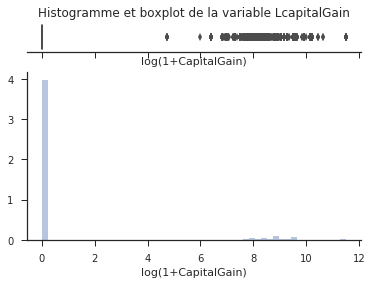

In [7]:
sns.set(style="ticks")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(adult["LcapitalGain"], ax=ax_box)
sns.distplot(adult["LcapitalGain"], norm_hist=True, ax=ax_hist, kde=False)

ax_box.set(yticks=[])
ax_hist.set(xlabel="log(1+CapitalGain)")
ax_box.set(xlabel="log(1+CapitalGain)")
ax_box.set(title="Histogramme et boxplot de la variable LcapitalGain")
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

**Q** Quels sont ces graphiques? Que dire de la transformation  opérée ? La variable CapitalLoss subit le même traitement.  
**R** Ce graphique représente un histogramme et un boxplot de la variable `LcapitalGain`. Cette variable est définie comme suit : $LcapitalGain=log(1+CapitalGain)$. D'après le graphique, on remarque que très peu d'individus ont un capital. La transformation consistant à prendre le logarithme permet de réduire les écarts entre les individus ayant un capital et ceux qui n'en ont pas.  
Il en est de même pour la variable `LcapitalLoss`.

/usr/local/insa/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/insa/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


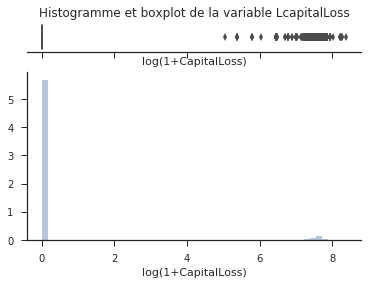

In [8]:
sns.set(style="ticks")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(adult["LcapitalLoss"], ax=ax_box)
sns.distplot(adult["LcapitalLoss"], norm_hist=True, ax=ax_hist, kde=False)

ax_box.set(yticks=[])
ax_hist.set(xlabel="log(1+CapitalLoss)")
ax_box.set(xlabel="log(1+CapitalLoss)")
ax_box.set(title="Histogramme et boxplot de la variable LcapitalLoss")
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

Nous rencontrons quelques problèmes avec certains individus :

In [9]:
pd.crosstab(adult["relationship"],adult["sex"])

sex,Female,Male
relationship,,
Husband,1,12460
Not-in-family,3566,4156
Other-relative,386,501
Own-child,1961,2504
Unmarried,2463,749
Wife,1405,1


Par le tableau ci dessus, on observe qu'un individu est à la fois `Husband` et `Female` par exemple. Il va falloir régler ce problème, et pour cela, on propose de supprimer ces valeurs aberrentes.

In [10]:
adult=adult[(adult["sex"]!="Female") | (adult["relationship"]!="Husband")]
adult=adult[(adult["sex"]!="Male") | (adult["relationship"]!="Wife")]

In [11]:
pd.crosstab(adult["relationship"],adult["sex"])

sex,Female,Male
relationship,,
Husband,0,12460
Not-in-family,3566,4156
Other-relative,386,501
Own-child,1961,2504
Unmarried,2463,749
Wife,1405,0


In [12]:
pd.crosstab(adult["education"],adult["educNum"])

educNum,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
Associates,0,0,0,0,0,0,0,0,0,0,1307,1008,0,0,0,0
Bachelors,0,0,0,0,0,0,0,0,0,0,0,0,5042,0,0,0
Doctorate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,375
Dropout,45,151,288,557,455,820,1048,376,0,0,0,0,0,0,0,0
HS-Graduate,0,0,0,0,0,0,0,0,9835,6676,0,0,0,0,0,0
Masters,0,0,0,0,0,0,0,0,0,0,0,0,0,1626,0,0
Prof-school,0,0,0,0,0,0,0,0,0,0,0,0,0,0,542,0


On remarque que `educNum` et `education` regroupent la même information, même si on perd de la précision avec la variable `education`. Travailler avec ces deux variables reviendrait à donner deux fois plus d'importance à la même information. On peut penser à garder `educNum` car c'est une variable quantitative ordonnée.

In [13]:
pd.crosstab(adult["mariStat"],adult["relationship"])

relationship,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
mariStat,,,,,,
Married,12460,14,118,84,0,1405
Never-married,0,4444,547,3928,801,0
Not-Married,0,2832,182,441,2068,0
Widowed,0,432,40,12,343,0


On va garder `maristat` car au final la précision de la variable `relationship` n'est pas nécessaire pour le reste de l'étude.

In [14]:
pd.crosstab(adult["origEthn"],adult["nativCountry"])

nativCountry,British-Commonwealth,China,Euro_1,Euro_2,Latin-America,Other,S-Asia,SE-Asia,United-States
origEthn,,,,,,,,,
Amer-Indian,0,1,1,2,10,0,0,1,270
Asian,88,122,2,71,6,6,18,309,273
Black,9,0,7,0,168,0,0,4,2628
Other,6,0,1,0,108,2,0,1,113
White,225,6,213,146,1061,34,0,30,24209


On va garder `origEthn` car `nativCountry` mélange les origines ethniques, et il n'est pas nécessaire d'avoir un tel niveau de précision pour la suite de l'aventure.

**Q** Quel est ce problème général ? Qu’est-ce qui va se passer si on en calcule l’analyse des correspondances ? Quel est le problème plus spécifique des variables `relationship` et `sex`?  
**R** ON NE CONNAIT PAS LA REPONSE A REPONDRE

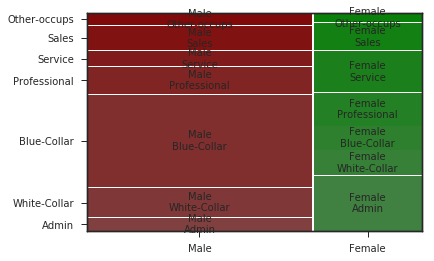

In [15]:
mosaic(adult, ["sex", "occup"])
plt.show()

**Q** Quel est le graphique ci-dessus?  Quelle interprétation ?  
**R** Le graphique ci dessus est un mosaic plot. Ce dernier permet de visualiser l'évolution simultanée des deux variables. La superficie d'une case est proportionnelle à l'effectif associé à la variable. Par le graphique on observe qu'il y a moins de femmes que d'hommes. On observe aussi que certains métiers sont typiquement masculins : c'est le cas par exemple pour `blue collar`. En effet, beaucoup d'hommes exercent cette profession, alors que très peu de femmes sont concernées.

In [16]:
tab=pd.crosstab(adult["sex"],adult["occup"])
print("p-valeur = ",scipy.stats.chi2_contingency(tab)[1])

p-valeur =  0.0


**Q** Quel est le test ci-dessous ? Que doit vérifier la table pour que ce test soit valide ? Quelle est l’hypothèse H0 testée ? Conclusion.  
**R** On teste si le genre est indépendant de la profession au niveau 0.05 par un test d'indépendance du Chi2. Pour pouvoir affectuer ce test, qui est un test assymptotique, il faut que les effectifs des différentes classes soient quand même assez grands (on considère les effectifs assez grands lorsqu'ils sont supérieurs à 5, ce qui est le cas). Au vu de la p-valeur qui vaut 0, on rejette l'hypothèse $H_0$ selon laquelle ces deux variables sont indépendantes.

**Q** Quel est le graphique ci-dessous? Comment interpréter? Quel test permettrait de confirmer ? Que dire de l’intérêt de cette variable [fnlwgt](http://web.cs.wpi.edu/~cs4341/C00/Projects/fnlwgt) (Final sampling weight)?  
**R** Le graphique ci dessous est un boxplot. On remarque que la variable `fnlwgt` n'a pas d'impact sur le niveau de revenu des individus. Cela se repère assez facilement sur le boxplot. En effet, les modalités `incHigh` et `incLow` ont les mêmes médianes et les mêmes quantiles. Nous allons vérifier cette hypothèse grâce à un test du Chi2.  
Une idée naïve pourrait être de supprimer cette variable `fnlwgt`, car l'explication sur son utilité est extrêmement floue et approximative, mais il semble ressortir de cette explication que la variable a un rôle de poids, permettant ainsi de pondérer les individus.

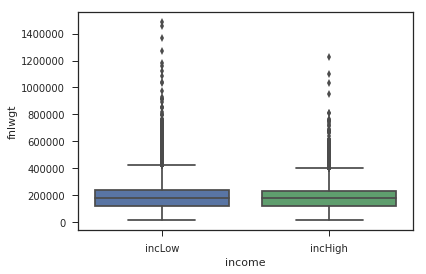

In [17]:
sns.boxplot(adult["income"],adult["fnlwgt"])
plt.show()

In [18]:
tab2=pd.crosstab(adult["income"],adult["fnlwgt"])
print("p-valeur = ",scipy.stats.chi2_contingency(tab2)[1])

p-valeur =  3.879362589597632e-06


La $p-valeur$ renvoyée est plus petite que 5% donc on rejette $H_0$, l'hypothèse selon laquelle les variables ne sont pas indépendantes. On peut donc considérer que `income` et `fnlwgt` sont indépendantes.

**Q** Que dire dans la figure ci-dessous de la liaison entre les variables `educNum` et `age` et de la localisation des points verts (>50k€) par rapport aux oranges (<50k€).  
**R** On remarque que plus le niveau d'éducation est élevé, plus le salaire est élevé aussi. De plus, parmis les individus ayant un niveau d'éducation élevé, le salaire augmente aussi en fonction de l'âge.

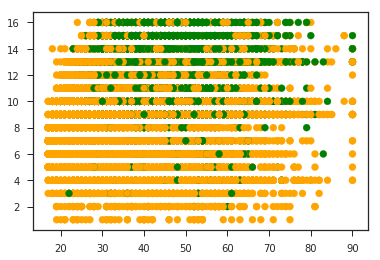

In [19]:
cat_name_dic = {'incHigh':"green", 
                'incLow': "orange"}

colors=adult.income.map(cat_name_dic)


plt.scatter(adult["age"], adult["educNum"], c=colors)
plt.show()

## 3 Analyse en composantes principales

In [20]:
adult_real=adult.copy()
adult_real = adult_real.drop("workClass", axis=1)
adult_real = adult_real.drop("education", axis=1)
adult_real = adult_real.drop("mariStat", axis=1)
adult_real = adult_real.drop("relationship", axis=1)
adult_real = adult_real.drop("income", axis=1)
adult_real = adult_real.drop("occup", axis=1)
adult_real = adult_real.drop("origEthn", axis=1)
adult_real = adult_real.drop("sex", axis=1)
adult_real = adult_real.drop("capitalGain", axis=1)
adult_real = adult_real.drop("capitalLoss", axis=1)
adult_real = adult_real.drop("nativCountry", axis=1)
print(adult_real)

       age  fnlwgt  educNum  hoursWeek  LcapitalGain  LcapitalLoss
0       39   77516       13         40      7.684784      0.000000
1       50   83311       13         13      0.000000      0.000000
2       38  215646        9         40      0.000000      0.000000
3       53  234721        7         40      0.000000      0.000000
4       28  338409       13         40      0.000000      0.000000
5       37  284582       14         40      0.000000      0.000000
6       49  160187        5         16      0.000000      0.000000
7       52  209642        9         45      0.000000      0.000000
8       31   45781       14         50      9.552866      0.000000
9       42  159449       13         40      8.552367      0.000000
10      37  280464       10         80      0.000000      0.000000
11      30  141297       13         40      0.000000      0.000000
12      23  122272       13         30      0.000000      0.000000
13      32  205019       12         50      0.000000      0.00

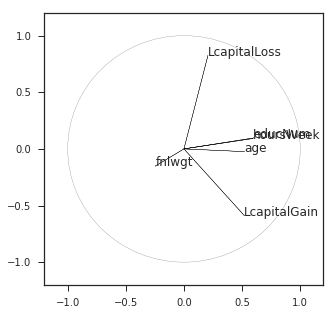

In [21]:
pca = PCA()
adultS=scale(adult_real)
cpOcde = pca.fit_transform(adultS)

coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, adult_real.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='black')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='gray', fill=False)
ax.add_patch(c)
plt.show()

**Q** La représentation ci-dessous montre un artefact avec 3 paquets d’individus. A quoi est dû cet artéfact ? Est-il utile à la compréhension des données ?   

  
**R** L'ACP n'est pas très interressante. Il y a trois tas : ceux qui n'ont pas d'actions en bourse, ceux qui ont perdu en bourse et ceux qui ont gagné en bourse. Il faudra faire une AFD.

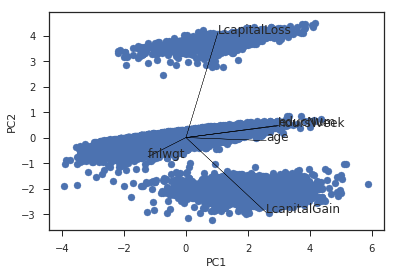

In [22]:
plt.scatter(cpOcde[:,0], cpOcde[:,1])
for i, j, nom in zip(coord1,coord2, adult_real.columns):
    plt.text(i*5, j*5, nom)
    plt.arrow(0,0,i*5,j*5,color='black')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## 4 [Analyse factorielle des correspondances](http://wikistat.fr/pdf/st-m-explo-afc.pdf) de la table `occup` *vs.* `education`
**Q** Que conclure du test ci-dessous sur l’intérêt d’une analyse des correspondances? Quelle est la table étudiée, ses dimensions?  
**R** On remarque que la p-valeur est petite donc on rejette l'hypothèse de l'indépendance des deux variables `occup` et `education`

In [23]:
tab3 = pd.crosstab(adult["education"],adult["occup"])
print("p-valeur = ",scipy.stats.chi2_contingency(tab3)[1])

p-valeur =  0.0


**Q** Quelles sont les ACPs considérées dans cette analyse des correspondances, avec quelles métriques?  
**R** On a fait une ACP des profils lignes et une ACP des profils colonnes de la variable `occup` puis de la variable `education`

**Q** Quelle est la matrice diagonalisée?  
**R** Pour les profils lignes, c'est la matrice $AB$ et pour les profils colonnes c'est la matrice $BA$

**Q** Quelle est la significaiton des valeurs (%) présentes dans les légendes?  
**R** Les % représentent l'inertie (ou le pourcentage de variance expliquée) portée par chaque dimension.

**Q** Donner en une ligne une signification à l’Axe 1.  
**R** L'axe 1 représente le niveau d'étude, avec des grandes valeurs pour des grandes études.

In [45]:
dc = pd.DataFrame(pd.get_dummies(adult[["education","occup"]]))
mcaFic = MCA(dc, ncols = 2, benzecri = True)

In [41]:
print(mcaFic.fs_c())

[[-0.04974068  0.18928929]
 [-0.69870037  0.22723759]
 [-1.83418898 -0.75090433]
 [ 0.6093829  -0.43397909]
 [ 0.30864972  0.05624285]
 [-1.27598702 -0.0999017 ]
 [-1.79821933 -0.82186569]
 [ 0.19495681  0.2673573 ]
 [ 0.47957274 -0.14755742]
 [-0.03000257  0.37345731]
 [-1.30535953 -0.2820777 ]
 [ 0.0297614   0.18861467]
 [ 0.50010229 -0.24533004]
 [-0.48692405  0.29371609]]


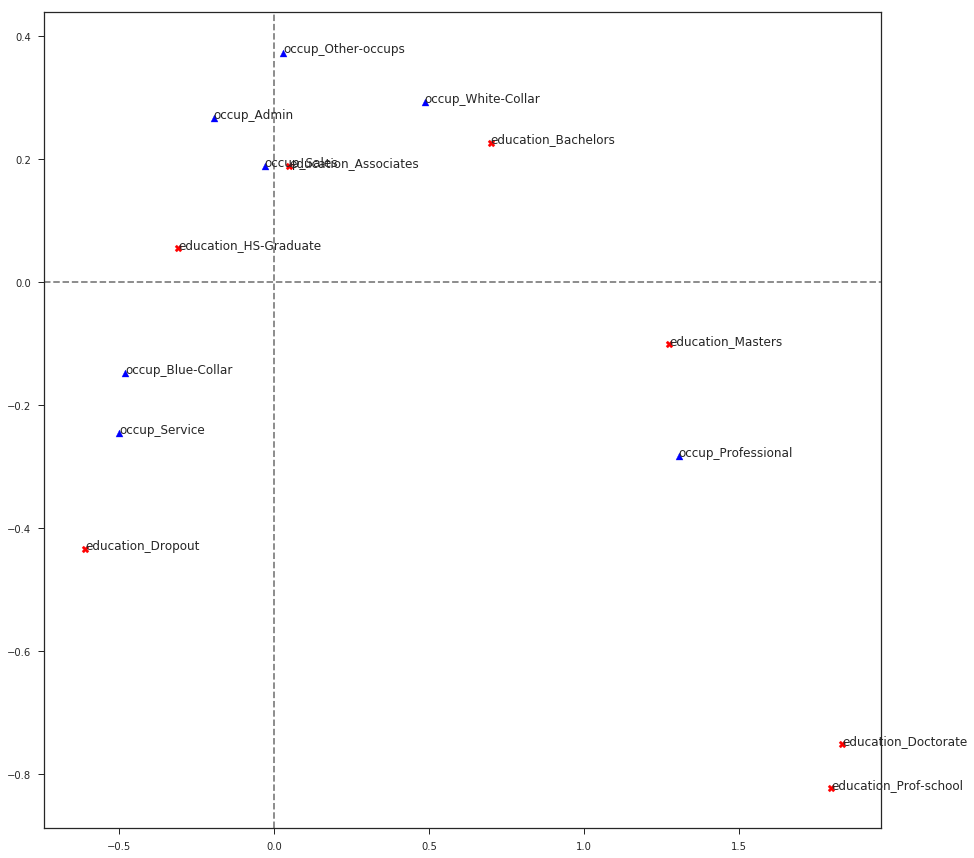

In [131]:
fig = plt.figure(figsize = (15,15))
dico_coul = {"education":'red', "occup":'blue'}
dico_form = {"education":'X', "occup":'^'}

for i, j, nom in zip(mcaFic.fs_c()[:, 0], mcaFic.fs_c()[:, 1], dc.columns):
    name = nom[:nom.find('_')]
    plt.scatter(-i ,j, c = dico_coul[name], marker = dico_form[name])
    plt.text(-i, j, nom)

plt.axhline(color = "grey", linestyle="--")
plt.axvline(color = "grey",linestyle="--")
plt.show()

## 5 [Analyse factorielle multiple des correspondances](http://wikistat.fr/pdf/st-m-explo-afcm.pdf)
**Q** La section 2 montre le peu d’intérêt de l’ACP. L’AFCM est donc utilisée. Quel prétraitement a été mis en œuvre pour y faire intervenir toutes les variables? Que faire des couples de variables posant problème (première section)?

**Q** Combien d’axes est-il raisonnable de retenir selon la figure ci-dessous? 

In [147]:
dataq=pd.DataFrame(pd.get_dummies(adult[["workClass", "education", "mariStat", "occup", "relationship", "origEthn","sex", "nativCountry", "income", "capitalGain", "capitalLoss"]]))

In [148]:
afcm = MCA(dataq, ncols = 11, benzecri = False)

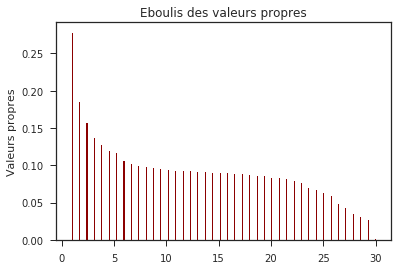

In [149]:
echelle = np.linspace(1,30,len(afcm.L))
plt.bar(echelle, afcm.L, width=0.1, color = "darkred")
plt.ylabel("Valeurs propres")
plt.title("Eboulis des valeurs propres")
plt.show()




#INTERPRETATION A FAIRE

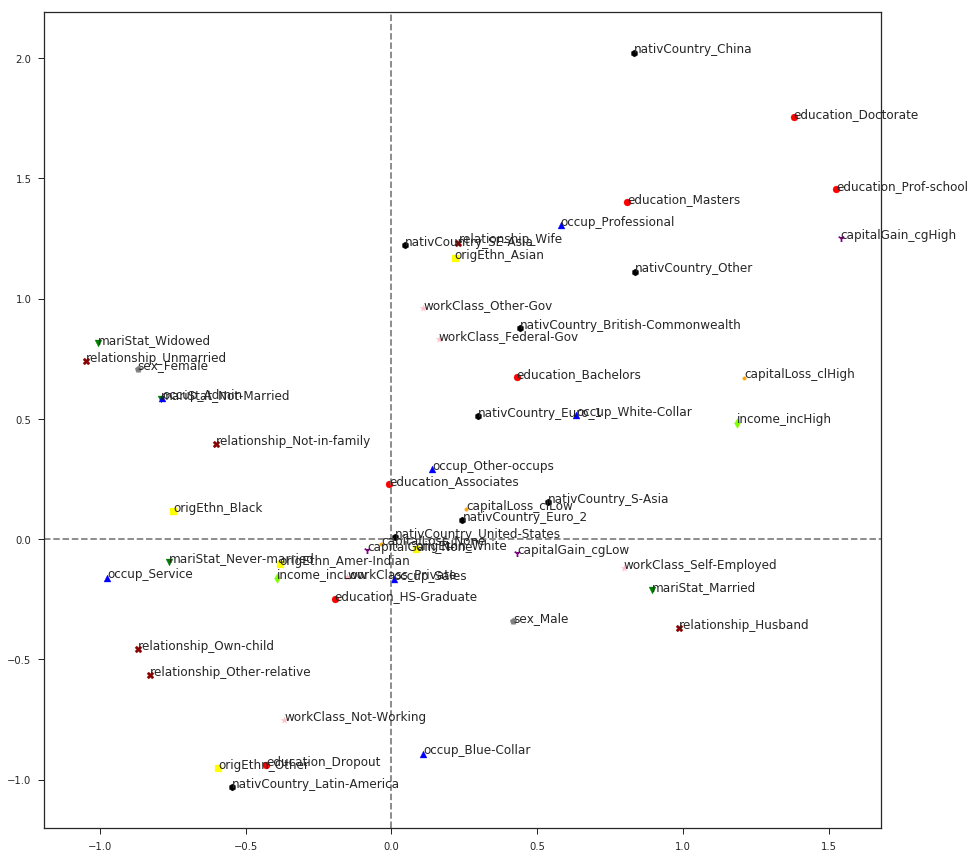

In [153]:
fig = plt.figure(figsize = (15,15))
dico_coul = {"workClass":'pink', "education":'red', "mariStat":'green', "occup":'blue', 
             "relationship":'darkred', "origEthn":'yellow', "sex":'grey', "nativCountry":'black', 
             "income":'chartreuse', "capitalGain":'purple', "capitalLoss":'orange'}
dico_form = {"workClass":'*', "education":'o', "mariStat":'v', "occup":'^', 
             "relationship":'X', "origEthn":'s', "sex":'p', "nativCountry":'h', 
             "income":'d', "capitalGain":'1', "capitalLoss":'.'}

for i, j, nom in zip(afcm.fs_c()[:, 0], afcm.fs_c()[:, 1], dataq.columns):
    name = nom[:nom.find('_')]
    
    #if name == 'LcapitalGai' :
    #    name = 'LcapitalGain'
    #elif name == 'LcapitalLos':
    #    name = 'LcapitalLoss'
        
    plt.scatter(i ,j, c = dico_coul[name], marker = dico_form[name])
    plt.text(i, j, nom)

plt.axhline(color = "grey", linestyle="--")
plt.axvline(color = "grey",linestyle="--")
plt.show()